Advanced lane finding
=====================

> The goals / steps of this project are the following: 
> * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
> * Apply a distortion correction to raw images.
> * Use color transforms, gradients, etc., to create a thresholded binary image.
> * Apply a perspective transform to rectify binary image ("birds-eye view").
> * Detect lane pixels and fit to find the lane boundary.
> * Determine the curvature of the lane and vehicle position with respect to center.
> * Warp the detected lane boundaries back onto the original image.
> * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Please see `README.md` for a detailed writeup.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import numpy as np
from moviepy.editor import VideoFileClip

from lib.constants import (IMG_SHAPE, LANE_AREA_SRC, LANE_AREA_DST,
                           SATURATION_THRESHOLD, SOBEL_X_ABS_SCALED_THRESHOLD)
from lib.camera_calib import Undistorter
from lib.lane_pixel_ops import binarize_lane_line_pixels, BirdsEyeTansformer
from lib.line import Line, LineType
from lib.road_lane import RoadLane

%matplotlib inline

In [3]:
IMG_PATH_INPUT = Path("./test_images")
IMG_PATH_OUTPUT = Path("./test_images_output")
VID_PATH_INPUT = Path("./test_videos")
VID_PATH_OUTPUT = Path("./test_videos_output")

PATH_CAM_CALIBRATION_IMAGES = list(Path("./camera_cal").glob("calibration*.jpg"))
TEST_IMAGES = sorted(IMG_PATH_INPUT.glob("*.jpg"))
TEST_VIDEOS = sorted(VID_PATH_INPUT.glob("*.mp4"))

In [4]:
undist = Undistorter(IMG_SHAPE)
undist.calibrate(PATH_CAM_CALIBRATION_IMAGES)

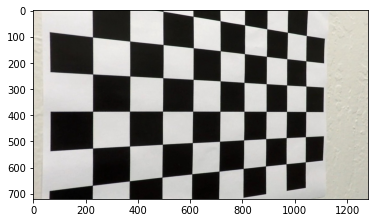

In [5]:
plt.imshow(undist.apply(plt.imread(PATH_CAM_CALIBRATION_IMAGES[0])))
plt.savefig(IMG_PATH_OUTPUT / "example-distortion-corrected.png")

In [6]:
bird_trans = BirdsEyeTansformer()

In [7]:
def visualize_undistorted_with_perspective_areas(ax, img):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title("Undistorted")
    
    ax.add_patch(Polygon(LANE_AREA_SRC, linewidth=1, edgecolor="lime", facecolor="none", 
                        linestyle="--", label="Transform source"))
    ax.add_patch(Polygon(LANE_AREA_DST, linewidth=1, edgecolor="pink", facecolor="none", 
                        linestyle="--", label="Transform destination"))
    ax.legend()

In [8]:
def visualize_lane_line(img_dist, img_bird, lane):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_bird).astype(np.uint8)
    color_warp = np.dstack([warp_zero] * 3)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([
        lane.left.plot_line_xs, 
        lane.left.plot_line_ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([
        lane.right.plot_line_xs, 
        lane.right.plot_line_ys])))])

    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, [pts], (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = bird_trans.revert(color_warp)

    # Combine the result with the original image
    img_combined = cv2.addWeighted(img_dist, 1, newwarp, 0.3, 0)
    
    cv2.putText(img_combined, f"radius of curvature: {lane.radius_of_curvature:.0f} m", (20, 75), 
                FONT, FONT_SIZE, FONT_COLOR)
    cv2.putText(img_combined, f"deviation from center: {lane.vehicle_rel_position:.2f} m", (20, 150), 
                FONT, FONT_SIZE, FONT_COLOR)

    return img_combined

In [9]:
FONT = cv2.FONT_HERSHEY_TRIPLEX
FONT_SIZE = 2
FONT_COLOR = (255, 255, 255)

def visualize_process_steps(img_path, img_dist, img, img_bin, img_bird, lane):
    _, ((t1, t2, t3, t4), (b1, b2, b3, b4)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))
    t1.imshow(cv2.cvtColor(img_dist, cv2.COLOR_BGR2RGB))
    t1.set_title("Original")
    
    visualize_undistorted_with_perspective_areas(t2, img)

    cmap = "gray" if len(img_bin.shape) == 2 else None
    t3.imshow(img_bin, cmap=cmap)
    t3.set_title("Lane pixel extraction")
    
    t4.imshow(img_bird, cmap=cmap)
    t4.set_title("Perspective transform")
    t4.grid()

    for lane_line, ax in zip((lane.left, lane.right), ((b1, b2))):
        ax.imshow(lane_line.sw_fit_viz)
        ax.set_title(f"{LineType.to_str(lane_line.line_type)} - "
                     f"radius of curvature: {lane_line.radius_of_curvature:.0f} m")

    img_lane = visualize_lane_line(img_dist, img_bird, lane)
    b3.imshow(cv2.cvtColor(img_lane, cv2.COLOR_BGR2RGB))
    b3.set_title("Visualize lane + metrics")

    b4.axis("off")
    
    plt.suptitle(f"{img_path.name} | "
                 f"radius of curvature: {lane.radius_of_curvature:.0f} m | "
                 f"deviation from center: {lane.vehicle_rel_position:.2f} m")
    plt.tight_layout(rect=[.1, .03, 1, .95])
    plt.savefig(str(IMG_PATH_OUTPUT / ("steps_" + img_path.stem + ".png")), dpi=100, bbox_inches="tight")
    plt.show()
    plt.close()

## Run pipeline on standalone test images
- Estimating line using sliding window approach
- No sanity checks
- Saving all intermediary outputs

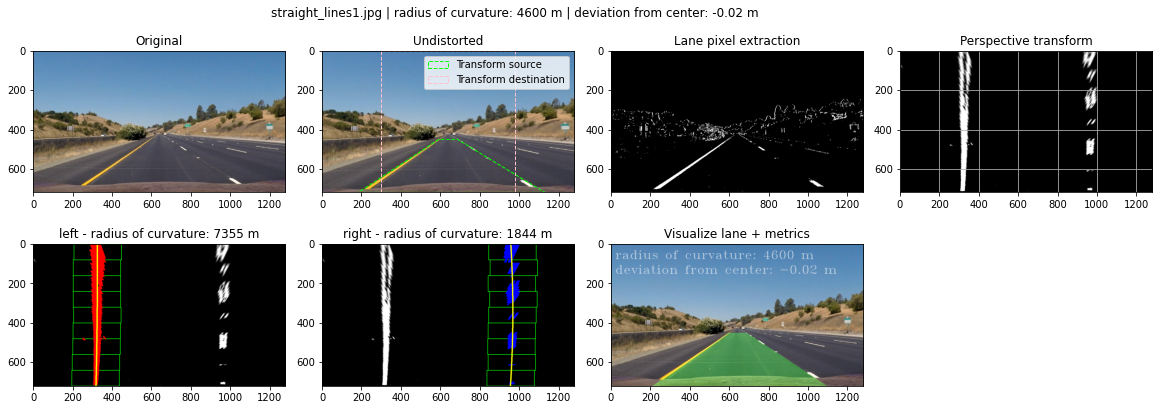

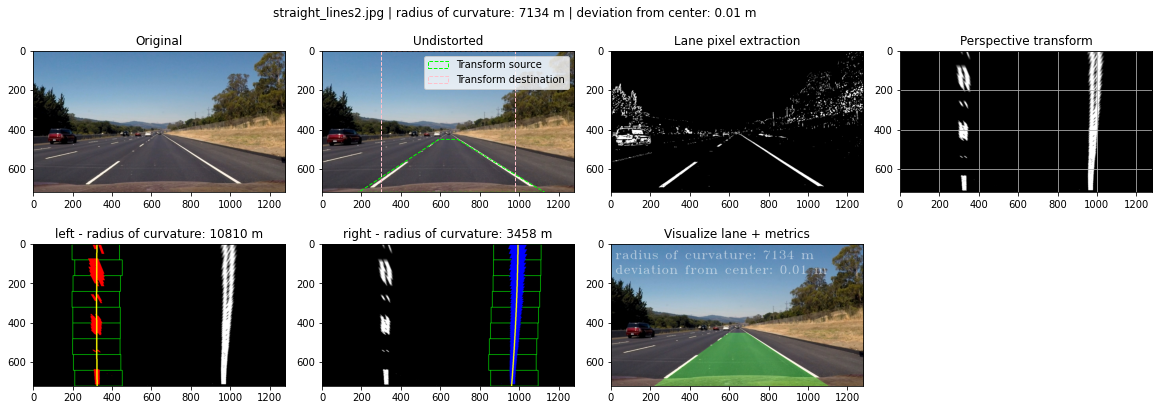

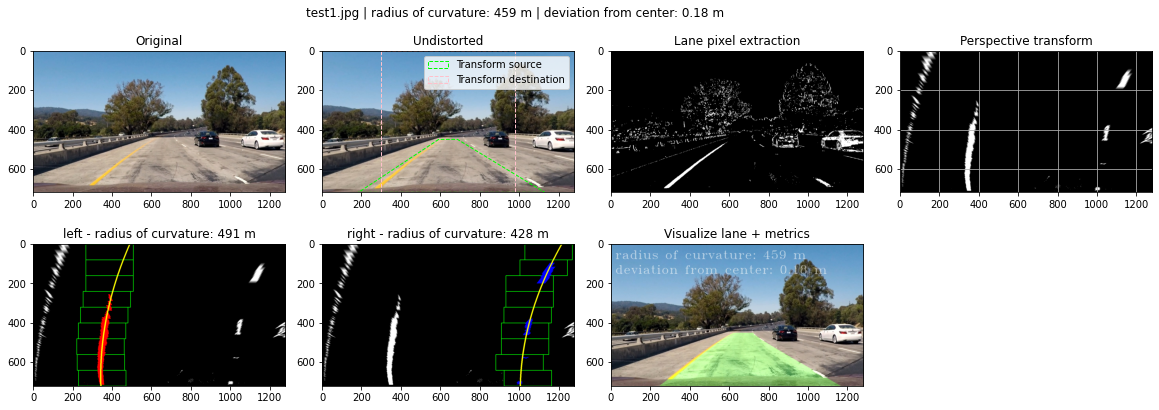

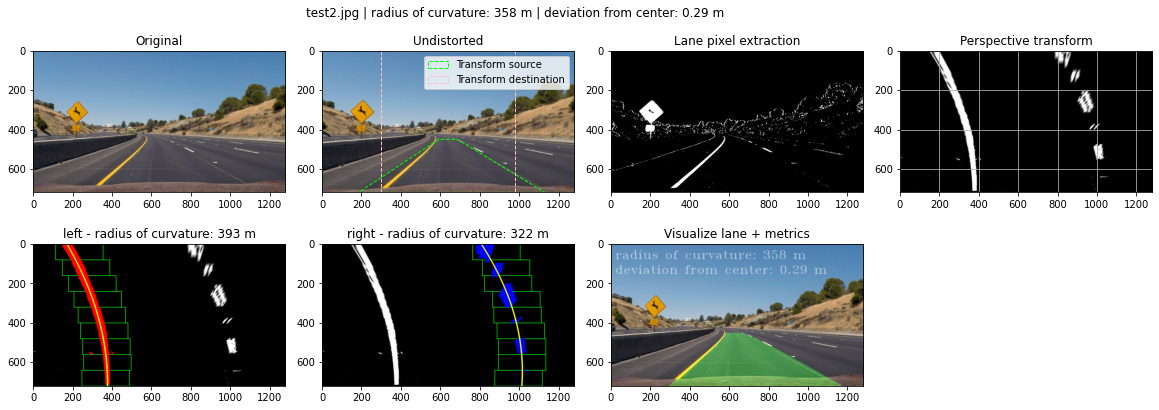

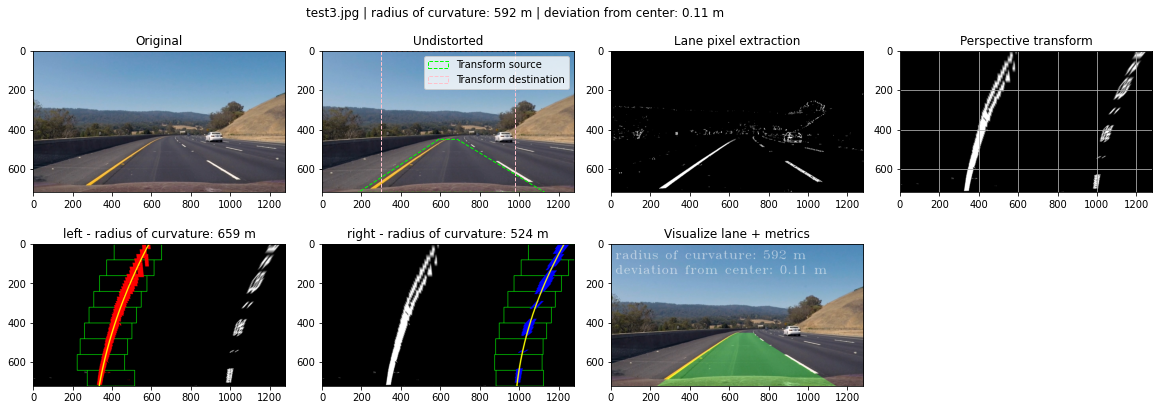

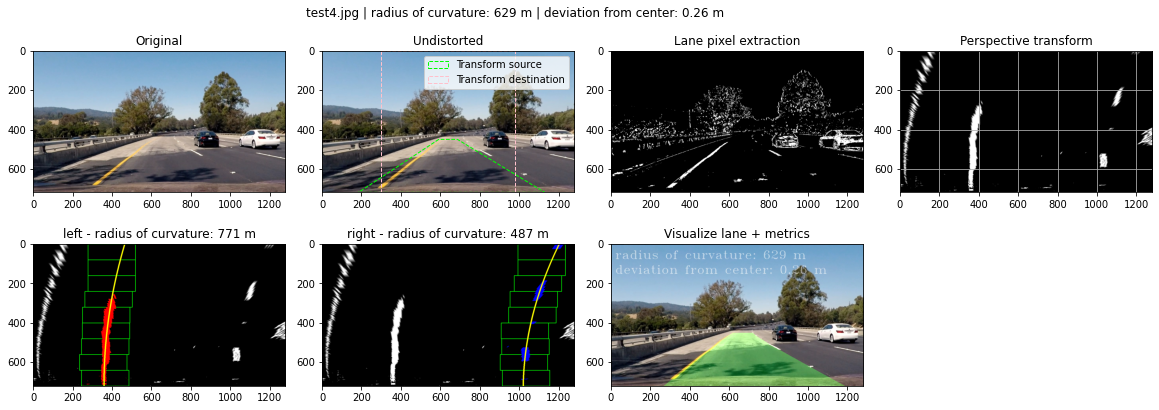

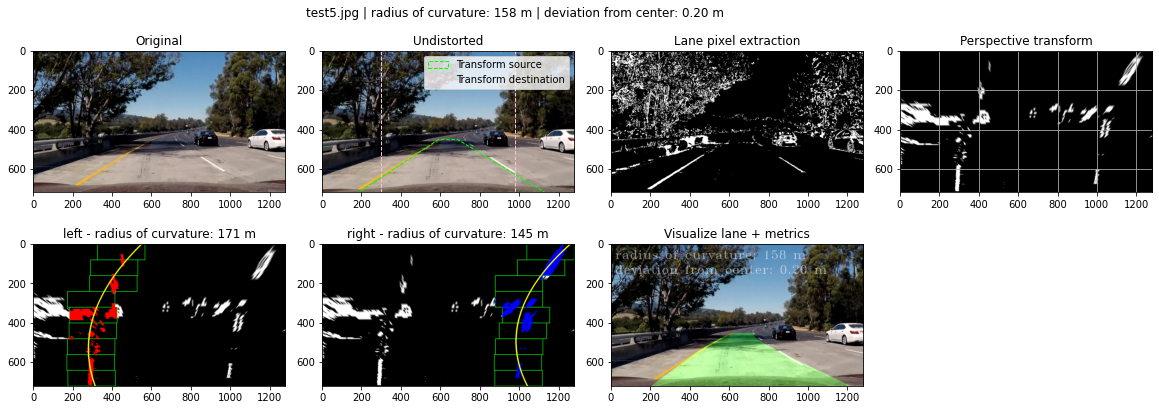

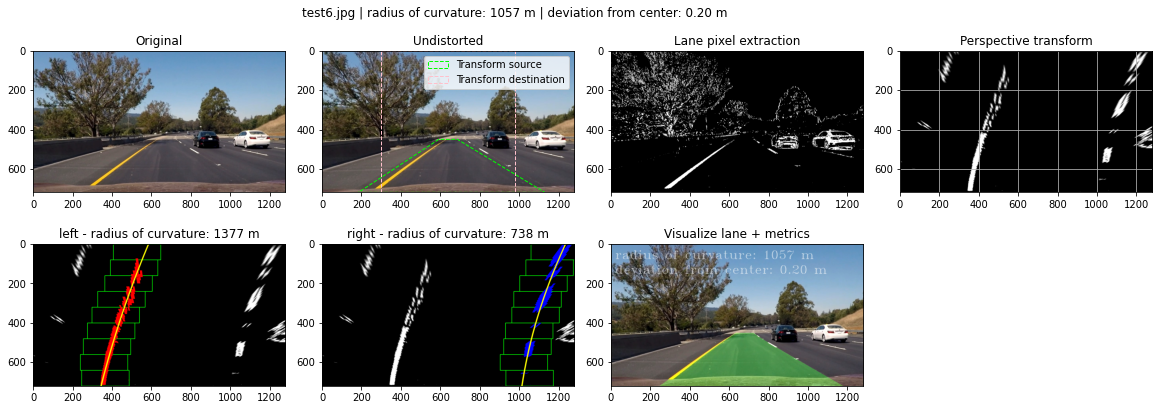

In [10]:
for img_path in TEST_IMAGES:
    img_dist = cv2.imread(str(img_path))
    img = undist.apply(img_dist)
    img_bin = binarize_lane_line_pixels(img, output_binary=True, 
                                        s_thresh=SATURATION_THRESHOLD,  
                                        sx_thresh=SOBEL_X_ABS_SCALED_THRESHOLD)
    img_bird = bird_trans.apply(img_bin)
    lane = RoadLane()
    lane.update(img_bird)
    visualize_process_steps(img_path, img_dist, img, img_bin, img_bird, lane)

## Run pipeline on videos
- Estimating line: initially with sliding window, then with lookahead filter (area around previous line)
- Sanity checks. Show previous for a few frames if not "sane". Reset if it can't recover within a reasonable time.
- Not saving intermediary output

In [11]:
def get_process_video_frame_func():
    lane = RoadLane()
    
    def process_video_frame(img_dist):
        nonlocal lane
        
        status_msg = ""
        
        # Internal assumptions are BGR while MoviePy reads as RGB. 
        # So, convert now and again when we return:
        img_dist = cv2.cvtColor(img_dist, cv2.COLOR_RGB2BGR)

        img = undist.apply(img_dist)
        img_bin = binarize_lane_line_pixels(img, output_binary=True, 
                                            s_thresh=SATURATION_THRESHOLD,  
                                            sx_thresh=SOBEL_X_ABS_SCALED_THRESHOLD)
        img_bird = bird_trans.apply(img_bin)
        
        status_msg = lane.update(img_bird)
        new_frame = visualize_lane_line(img_dist, img_bird, lane)

        if status_msg:
            cv2.putText(new_frame, status_msg, (20, 225), 
                        FONT, FONT_SIZE, FONT_COLOR)
        
#         print(new_frame.shape)
        img_bird_3d = np.repeat((img_bird.astype(np.uint8) * 255)[:, :, np.newaxis], 3, axis=2)
#         print(img_bird_3d.shape)
        side_by_side_frame = np.hstack((new_frame, img_bird_3d))
#         print(side_by_side_frame.shape)

        return cv2.cvtColor(side_by_side_frame, cv2.COLOR_BGR2RGB)
    
    return process_video_frame

In [13]:
vid_path = VID_PATH_INPUT / "project_video.mp4"
clip = VideoFileClip(str(vid_path))
clip = clip.subclip(1, 5)
clip_processed = clip.fl_image(get_process_video_frame_func())
clip_processed.write_videofile(str(VID_PATH_OUTPUT / (vid_path.stem + "_sample" + ".mp4"))) 

t:   0%|          | 0/100 [00:00<?, ?it/s, now=None]   

Moviepy - Building video test_videos_output/project_video_sample.mp4.
MoviePy - Writing audio in project_video_sampleTEMP_MPY_wvf_snd.mp3
MoviePy - Done.
Moviepy - Writing video test_videos_output/project_video_sample.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video_sample.mp4


In [ ]:
for vid_path in TEST_VIDEOS:
    print(f"\nStarting on {vid_path}....")
    clip = VideoFileClip(str(vid_path))
    clip_processed = clip.fl_image(get_process_video_frame_func())
    clip_processed.write_videofile(str(VID_PATH_OUTPUT / vid_path.name)) 


Starting on test_videos/challenge_video.mp4....


chunk:  29%|██▊       | 102/357 [00:00<00:00, 903.17it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video.mp4.
MoviePy - Writing audio in challenge_videoTEMP_MPY_wvf_snd.mp3


t:   1%|          | 3/485 [00:00<00:29, 16.54it/s, now=None]        

MoviePy - Done.
Moviepy - Writing video test_videos_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4

Starting on test_videos/harder_challenge_video.mp4....


chunk:   9%|▉         | 98/1058 [00:00<00:00, 979.81it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
MoviePy - Writing audio in harder_challenge_videoTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1199 [00:00<01:10, 16.97it/s, now=None]        

MoviePy - Done.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4

Starting on test_videos/project_video.mp4....


chunk:   9%|▉         | 102/1112 [00:00<00:01, 970.02it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
MoviePy - Writing audio in project_videoTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1260 [00:00<01:14, 16.96it/s, now=None]        

MoviePy - Done.
Moviepy - Writing video test_videos_output/project_video.mp4



t:  79%|███████▉  | 995/1260 [01:34<00:23, 11.16it/s, now=None]